In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 42

random.seed(seed)
np.random.seed(seed)
%matplotlib inline

def score_glrm(pred_frame, truth_frame, clean_col_names=True):
    cols_used = [c[9:] for c in pred_frame.columns] if clean_col_names else pred_frame.columns
    h_scoring = truth_frame[cols_used]
    correct = (pred_frame == h_scoring).as_data_frame()
    return np.sum(np.sum(correct)) / (correct.shape[0] * correct.shape[1])

## Load H2o

NOTE: to start H2o, first use Terminal to navigate to *usr/local/lib/python3.6/site-packages/h2o/backend/bin* and enter the command *java -jar h2o.jar*

In [2]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 mins 57 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 10 days
H2O cluster name:,jason
H2O cluster total nodes:,1
H2O cluster free memory:,69.7 Gb
H2O cluster total cores:,48
H2O cluster allowed cores:,48
H2O cluster status:,"locked, healthy"


## Load data

In [3]:
khous_df_full = pd.read_csv('khous_train.csv')

In [4]:
khous_df = khous_df_full.drop(['Id'], axis=1)
khous_df = khous_df.dropna(axis=1,how='all',thresh=int(khous_df.shape[1]*0.99))
khous_df.shape

(1460, 78)

In [5]:
# Check types and columns
with pd.option_context('display.max_rows', None):
    display(khous_df.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


In [6]:
# look at data values for each column
with pd.option_context('display.max_columns', None):
    display(khous_df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,MnPrv,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NaN,0,1,2008,WD,Norm

In [7]:
# set up the ideal loss functions
loss_by_col = {
    'MSSubClass':        'categorical',
    'MSZoning':          'categorical',
    'LotFrontage':         'quadratic',
    'LotArea':             'quadratic',
    'Street':            'categorical',
    'Alley':             'categorical',
    'LotShape':          'categorical',
    'LandContour':       'categorical',
    'Utilities':         'categorical',
    'LotConfig':         'categorical',
    'LandSlope':         'categorical',
    'Neighborhood':      'categorical',
    'Condition1':        'categorical',
    'Condition2':        'categorical',
    'BldgType':          'categorical',
    'HouseStyle':        'categorical',
    'OverallQual':           'ordinal',
    'OverallCond':           'ordinal',
    'YearBuilt':             'poisson',
    'YearRemodAdd':          'poisson',
    'RoofStyle':         'categorical',
    'RoofMatl':          'categorical',
    'Exterior1st':       'categorical',
    'Exterior2nd':       'categorical',
    'MasVnrType':        'categorical',
    'MasVnrArea':          'quadratic',
    'ExterQual':         'categorical',
    'ExterCond':         'categorical',
    'Foundation':        'categorical',
    'BsmtQual':          'categorical',
    'BsmtCond':          'categorical',
    'BsmtExposure':      'categorical',
    'BsmtFinType1':      'categorical',
    'BsmtFinSF1':          'quadratic',
    'BsmtFinType2':      'categorical',
    'BsmtFinSF2':          'quadratic',
    'BsmtUnfSF':           'quadratic',
    'TotalBsmtSF':         'quadratic',
    'Heating':           'categorical',
    'HeatingQC':         'categorical',
    'CentralAir':              'hinge',
    'Electrical':        'categorical',
    '1stFlrSF':            'quadratic',
    '2ndFlrSF':            'quadratic',
    'LowQualFinSF':        'quadratic',
    'GrLivArea':           'quadratic',
    'BsmtFullBath':          'ordinal',
    'BsmtHalfBath':          'ordinal',
    'FullBath':              'ordinal',
    'HalfBath':              'ordinal',
    'BedroomAbvGr':          'ordinal',
    'KitchenAbvGr':          'ordinal',
    'KitchenQual':       'categorical',
    'TotRmsAbvGrd':          'ordinal',
    'Functional':        'categorical',
    'Fireplaces':            'ordinal',
    'FireplaceQu':       'categorical',
    'GarageType':        'categorical',
    'GarageYrBlt':           'poisson',
    'GarageFinish':      'categorical',
    'GarageCars':            'ordinal',
    'GarageArea':          'quadratic',
    'GarageQual':        'categorical',
    'GarageCond':        'categorical',
    'PavedDrive':              'hinge',
    'WoodDeckSF':          'quadratic',
    'OpenPorchSF':         'quadratic',
    'EnclosedPorch':       'quadratic',
    '3SsnPorch':           'quadratic',
    'ScreenPorch':         'quadratic',
    'PoolArea':            'quadratic',
    'Fence':             'categorical',
    'MiscVal':             'quadratic',
    'MoSold':                'poisson',
    'YrSold' :               'poisson',
    'SaleType':          'categorical',
    'SaleCondition':     'categorical',
    'SalePrice':           'quadratic'
}

In [8]:
# verify they're all covered
khous_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [9]:
# drop "sold..." data, including SalePrice
khous_cols = khous_df.columns
khous_run = khous_df.loc[:, list(khous_df.columns[:-5]) + list(['SalePrice'])] 
print(khous_run.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [10]:
#set 25% to missing
khous_run_missing = khous_run.mask(np.random.random(khous_run.shape) < .25)
khous_run_missing.isna().head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal
0,False,False,False,False,True,True,True,False,False,False,...,False,False,False,True,False,True,False,False,True,True
1,False,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2,False,False,True,False,False,True,True,False,False,True,...,True,False,False,False,True,False,True,False,True,False
3,False,False,False,True,False,True,True,False,False,False,...,False,True,False,True,False,False,False,False,True,True
4,False,False,True,False,False,True,False,True,True,False,...,False,True,False,False,False,False,False,False,True,False


## Convert data to H2o

In [11]:
khous_h2 = h2o.H2OFrame(khous_run)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
#see and fix H2O data types
types = {}
typeconv = {
    'categorical': 'categorical',
    'ordinal': 'factor',
    'hinge': 'numeric',
    'quadratic': 'float',
    'poisson': 'int'
}
for k in khous_h2.types:
    types[k] = typeconv[loss_by_col[k]]
column_types = list([types[t] for t in types])
column_types

['categorical',
 'categorical',
 'float',
 'float',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'factor',
 'factor',
 'int',
 'int',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'float',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'float',
 'categorical',
 'float',
 'float',
 'float',
 'categorical',
 'categorical',
 'numeric',
 'categorical',
 'float',
 'float',
 'float',
 'float',
 'factor',
 'factor',
 'factor',
 'factor',
 'factor',
 'factor',
 'categorical',
 'factor',
 'categorical',
 'factor',
 'categorical',
 'categorical',
 'int',
 'categorical',
 'factor',
 'float',
 'categorical',
 'categorical',
 'numeric',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'categorical',
 'float']

In [13]:
# set up final H2O frames
khous_h2 = h2o.H2OFrame(khous_run, column_types=column_types)
khous_null_h2 = h2o.H2OFrame(khous_run_missing, column_types=column_types)
khous_h2.types

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


{'1stFlrSF': 'int',
 '2ndFlrSF': 'int',
 '3SsnPorch': 'int',
 'Alley': 'enum',
 'BedroomAbvGr': 'enum',
 'BldgType': 'enum',
 'BsmtCond': 'enum',
 'BsmtExposure': 'enum',
 'BsmtFinSF1': 'int',
 'BsmtFinSF2': 'int',
 'BsmtFinType1': 'enum',
 'BsmtFinType2': 'enum',
 'BsmtFullBath': 'enum',
 'BsmtHalfBath': 'enum',
 'BsmtQual': 'enum',
 'BsmtUnfSF': 'int',
 'CentralAir': 'int',
 'Condition1': 'enum',
 'Condition2': 'enum',
 'Electrical': 'enum',
 'EnclosedPorch': 'int',
 'ExterCond': 'enum',
 'ExterQual': 'enum',
 'Exterior1st': 'enum',
 'Exterior2nd': 'enum',
 'Fence': 'enum',
 'FireplaceQu': 'enum',
 'Fireplaces': 'enum',
 'Foundation': 'enum',
 'FullBath': 'enum',
 'Functional': 'enum',
 'GarageArea': 'int',
 'GarageCars': 'enum',
 'GarageCond': 'enum',
 'GarageFinish': 'enum',
 'GarageQual': 'enum',
 'GarageType': 'enum',
 'GarageYrBlt': 'int',
 'GrLivArea': 'int',
 'HalfBath': 'enum',
 'Heating': 'enum',
 'HeatingQC': 'enum',
 'HouseStyle': 'enum',
 'KitchenAbvGr': 'enum',
 'Kitchen

## Build Models

In [14]:
# parameter sweep (one example).  Should sweep through k, multi_loss, init, and perhaps col types
glrmodel_2 = H2OGeneralizedLowRankEstimator(
                                       k=25,
                                       seed=seed,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       max_iterations=10000, 
                                       multi_loss='categorical',
                                       init='SVD',
                                       svd_method='gram_s_v_d',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [15]:
#glrmodel_2.train(x=khous_h2.names, training_frame=khous_null_h2, validation_frame=khous_h2)
glrmodel_2.train(x=khous_h2.names, training_frame=khous_h2)


glrm Model Build progress: |██████████████████████████████████████████████| 100%


## Test and use model

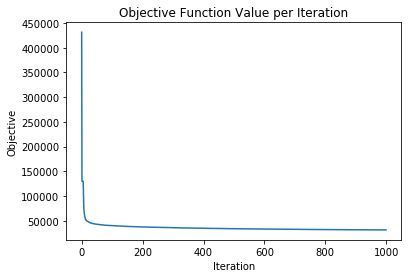

In [16]:
# Plot objective function value each iteration
model_score = glrmodel_2.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [17]:
model = glrmodel_2._model_json
model_out = model['output']
num_archs = glrmodel_2.params['k']['actual']
importance = list(model_out['importance'].cell_values[1])
archs = np.array(model_out["archetypes"].as_data_frame())
X = h2o.get_frame(model_out['representation_name'])
print('Original:', khous_run.shape)
print('Projected:', X.shape)

Original: (1460, 73)
Projected: (1460, 25)


['Proportion of Variance', 0.6214903791666916, 0.09468275736768386, 0.039322774915925535, 0.034858827043469244, 0.027370299417809454, 0.023309927443895876, 0.02279923441851116, 0.020304258446277514, 0.017511993926507124, 0.015665332364734094, 0.013260091220487909, 0.011586370580031943, 0.010067947092462042, 0.008927000678074374, 0.007922299148479412, 0.006224645024655301, 0.005317200477540282, 0.0042392403454697206, 0.0034203111987657453, 0.002980901887709717, 0.002490713904206251, 0.0023920557989979335, 0.0015047196339797576, 0.0012813134791229207, 0.001069405018510994]


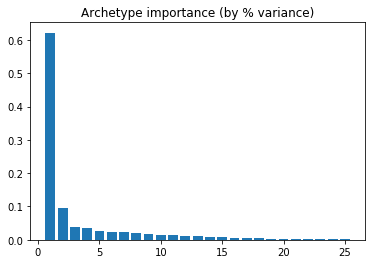

In [18]:
print(importance)
plt.bar(range(1,len(importance)), importance[1:])
plt.title('Archetype importance (by % variance)')

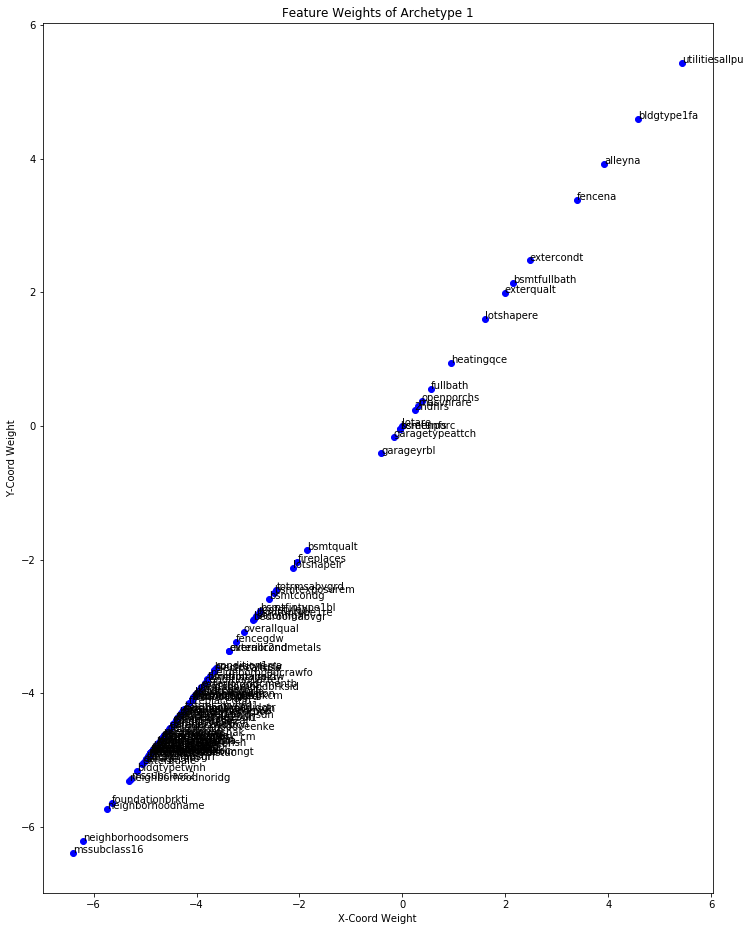

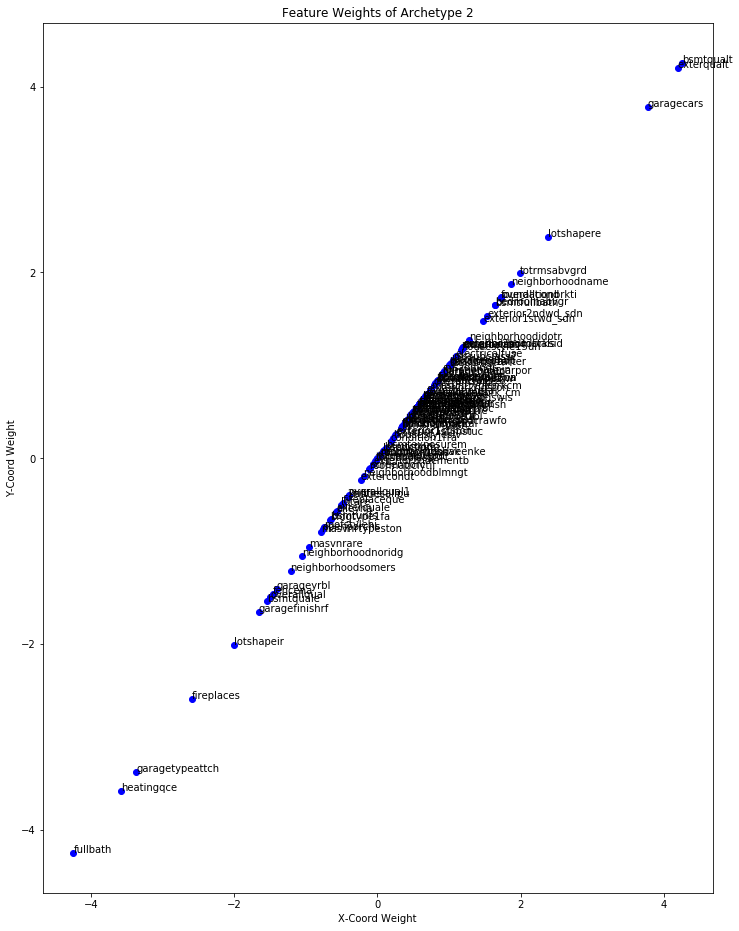

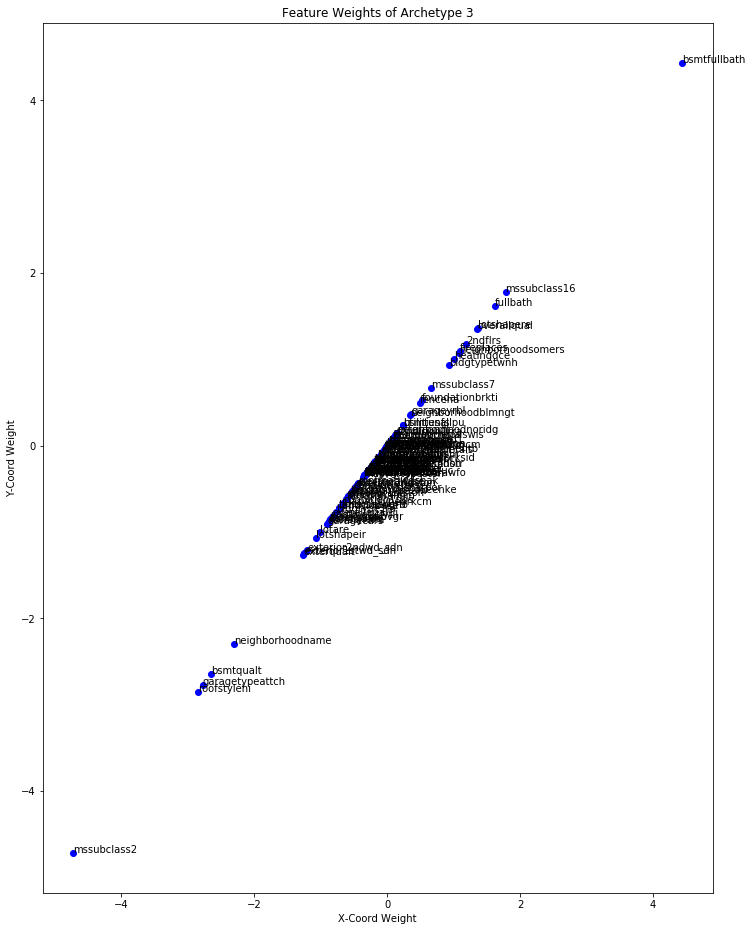

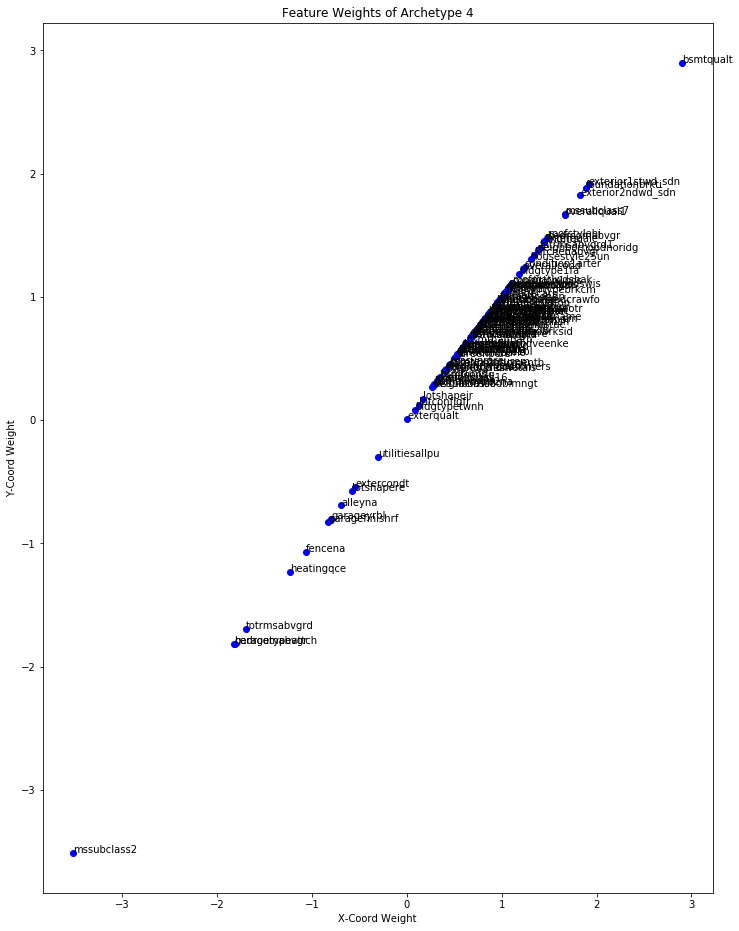

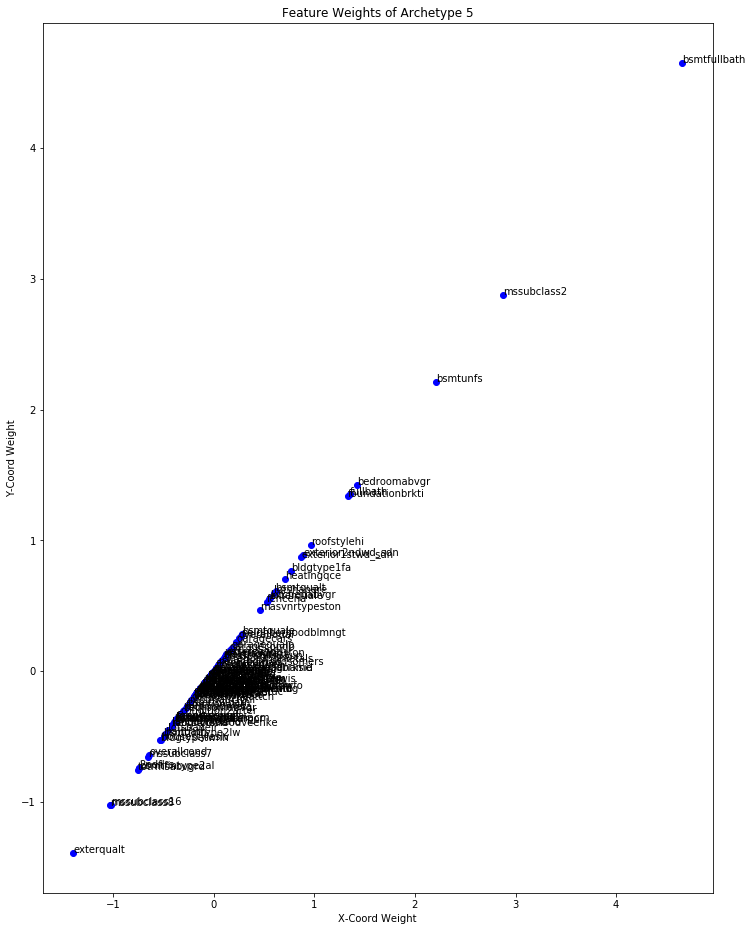

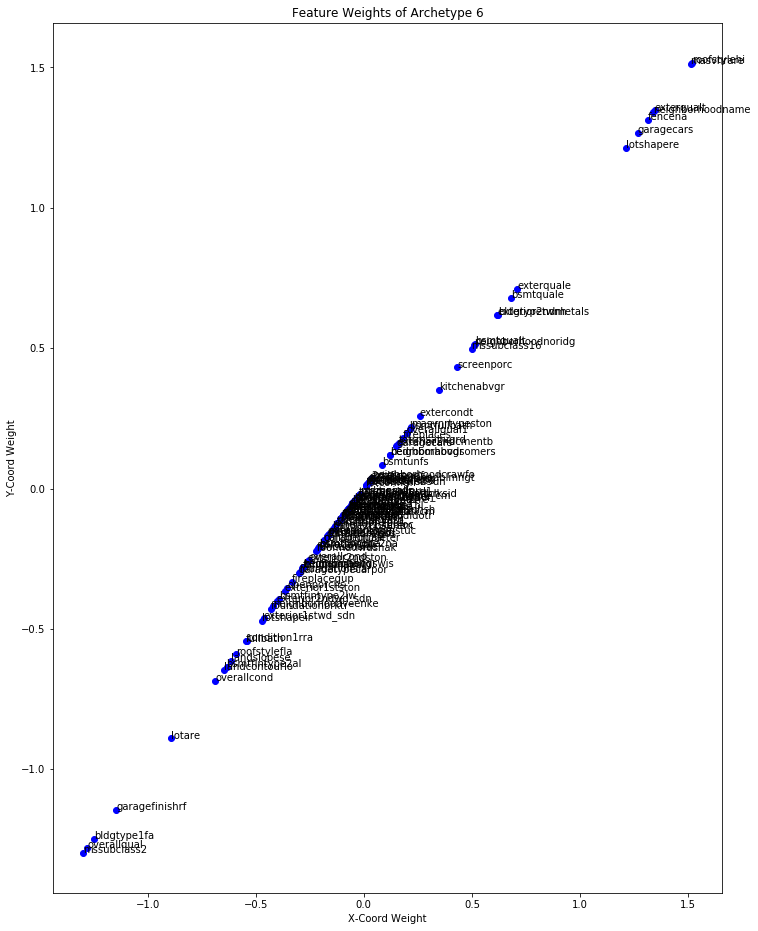

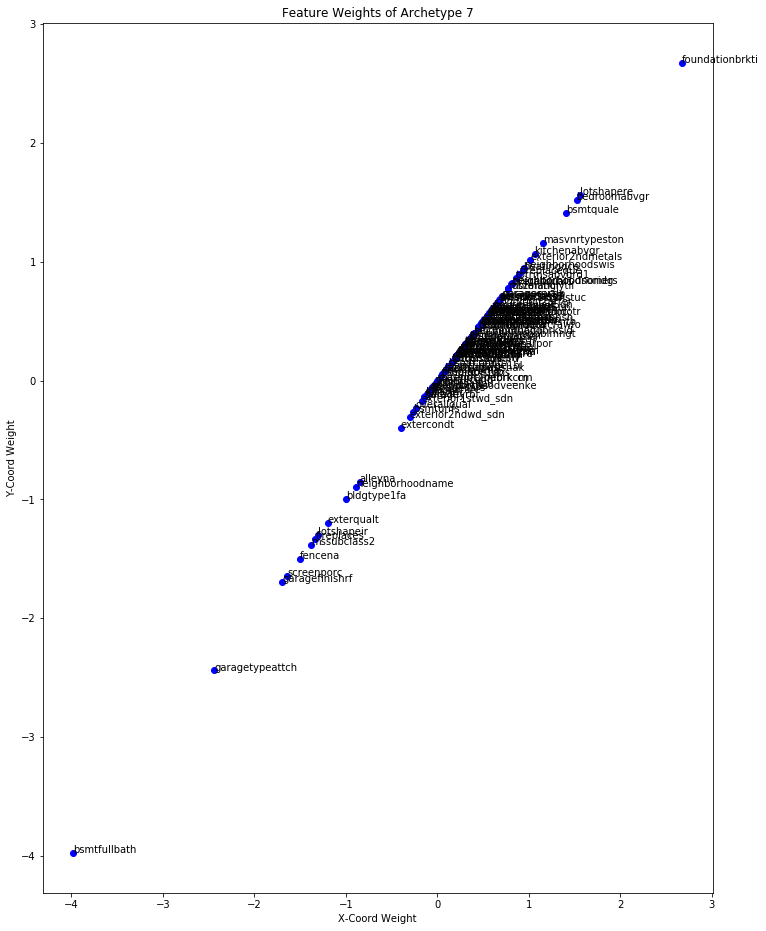

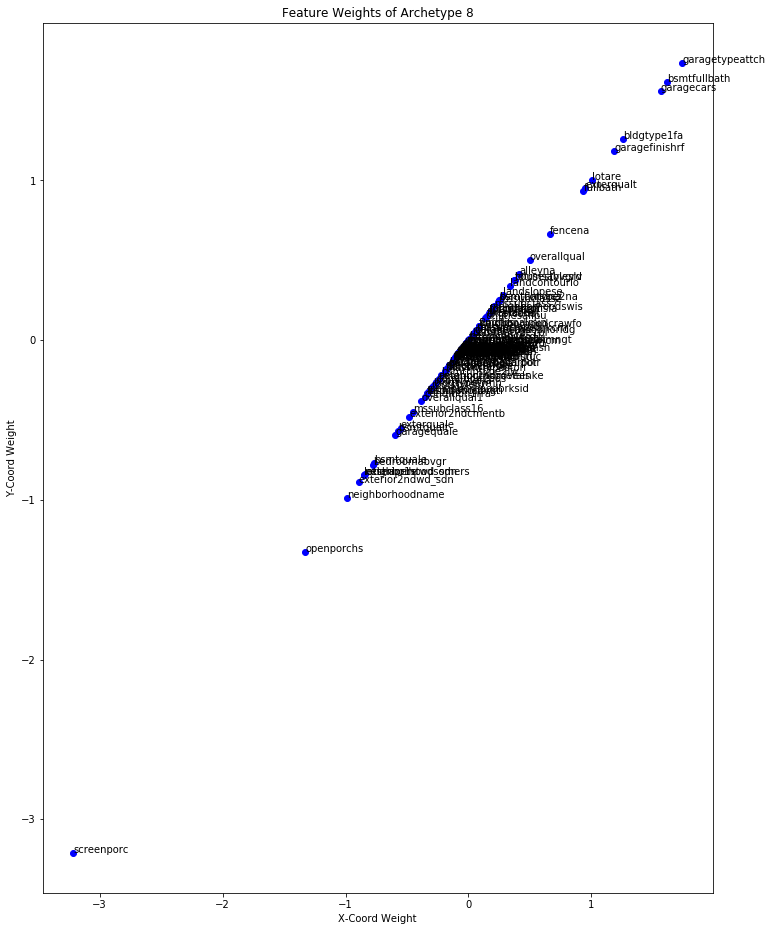

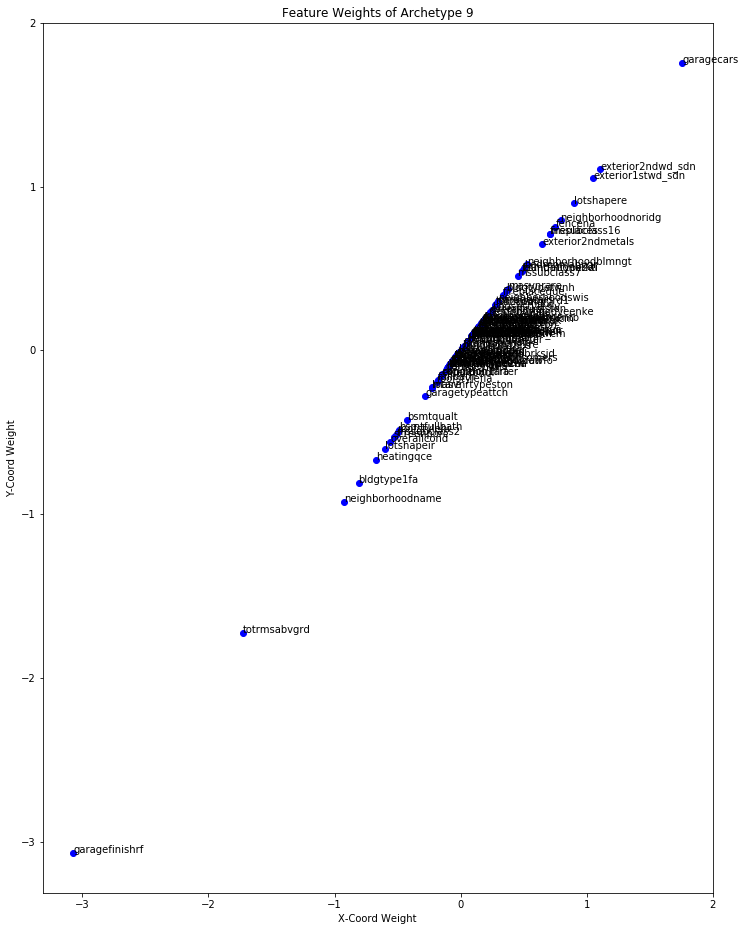

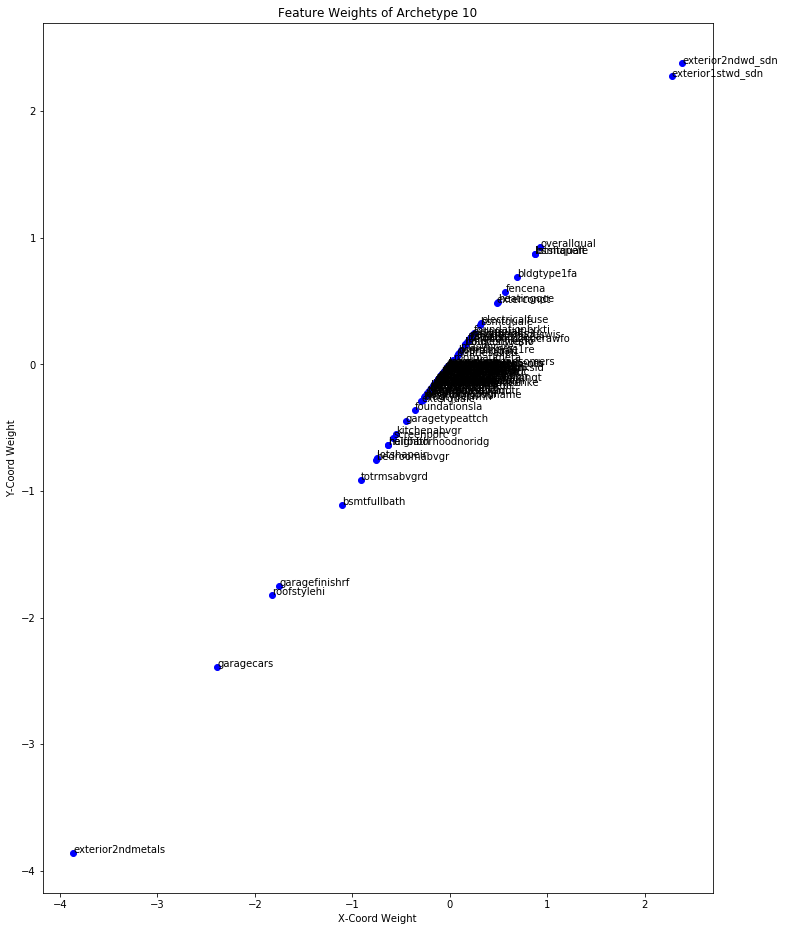

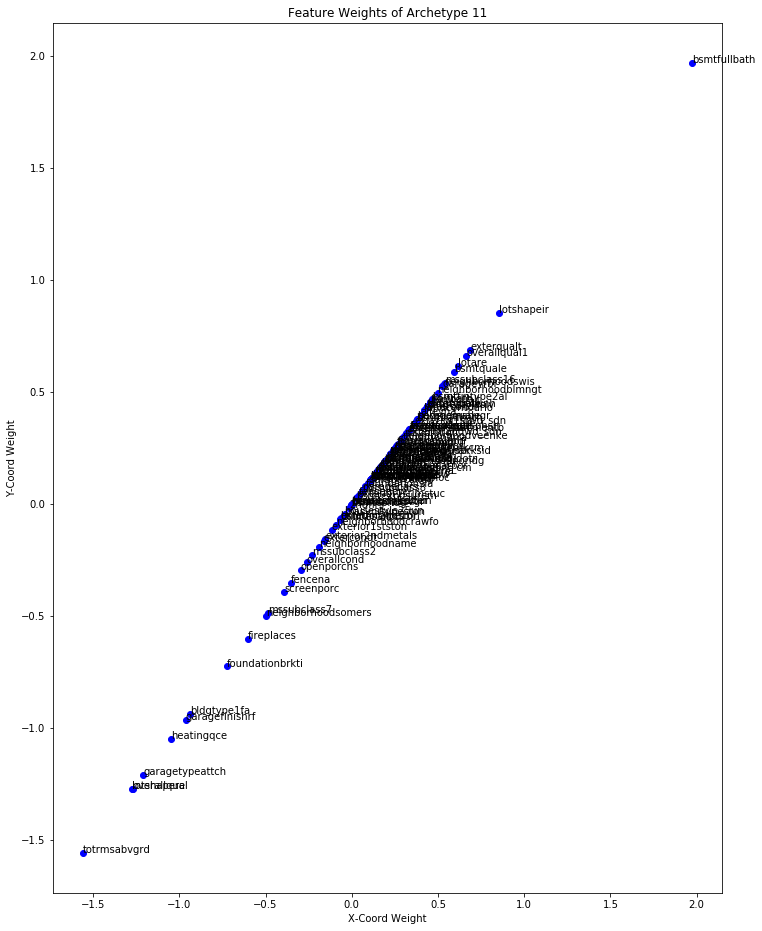

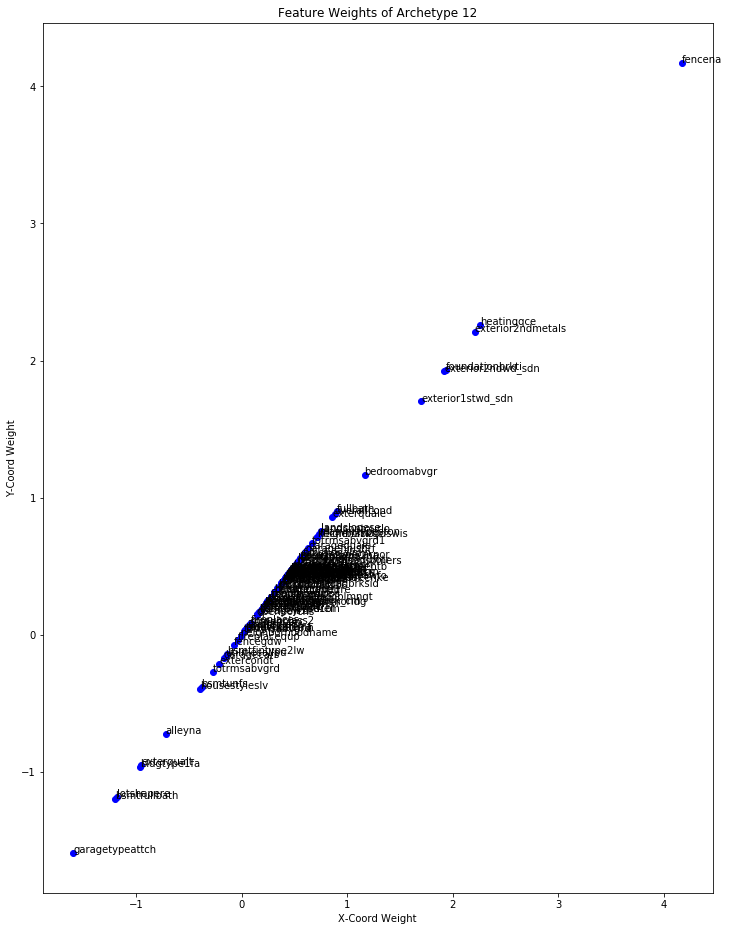

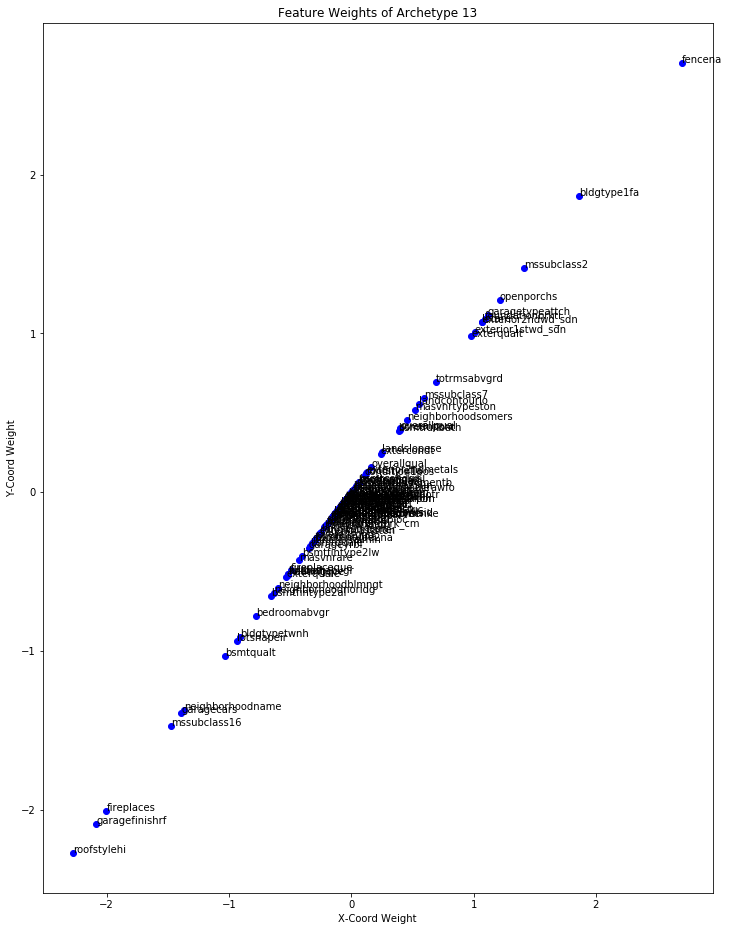

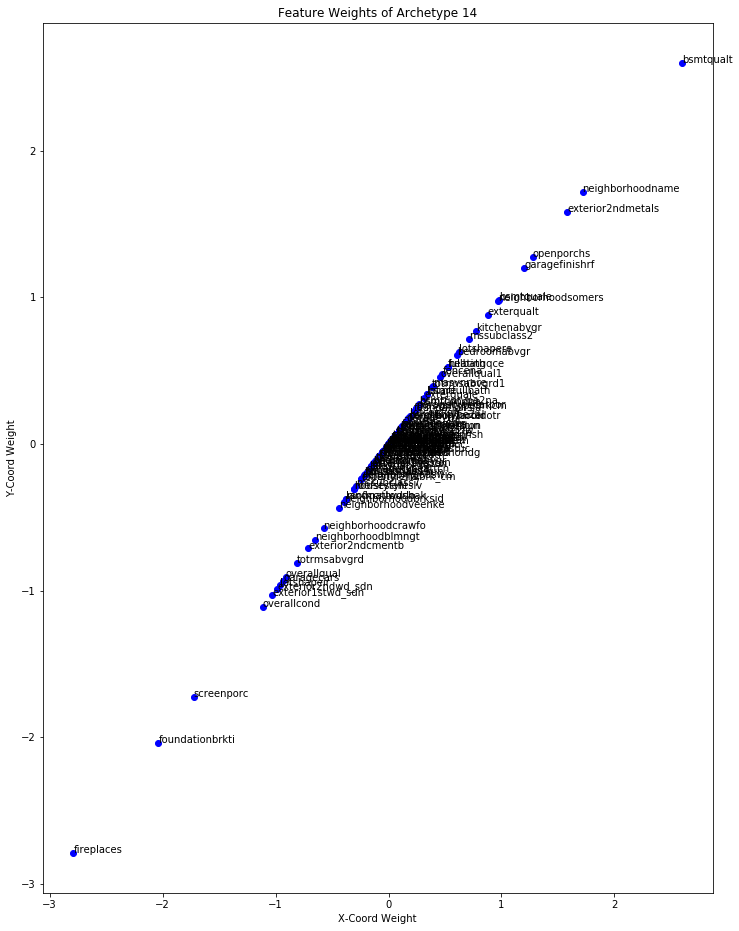

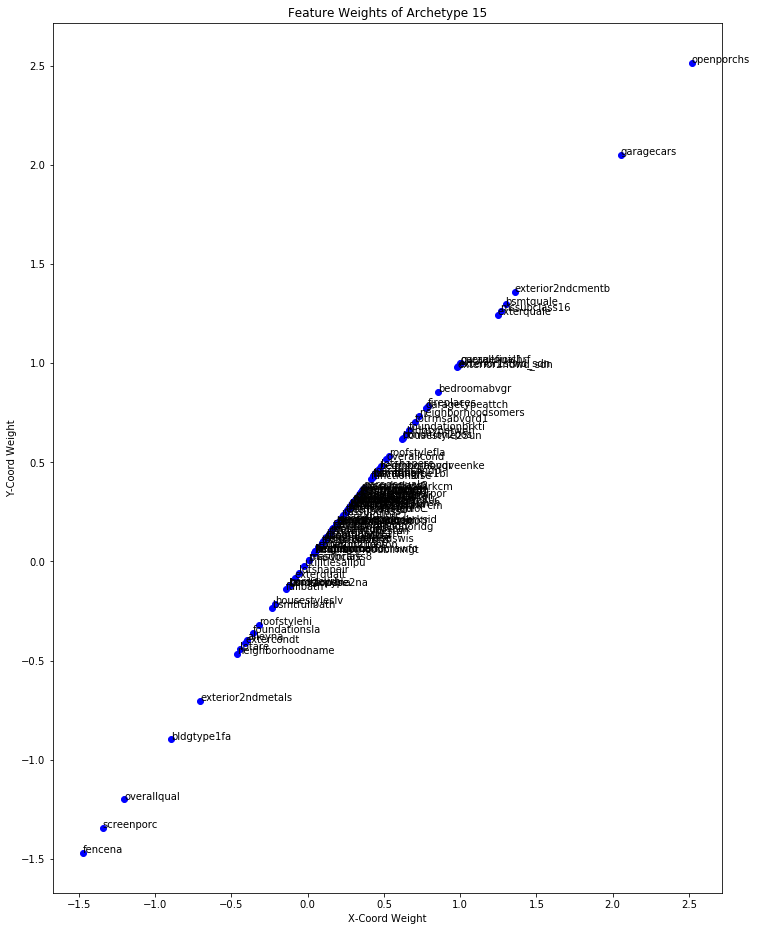

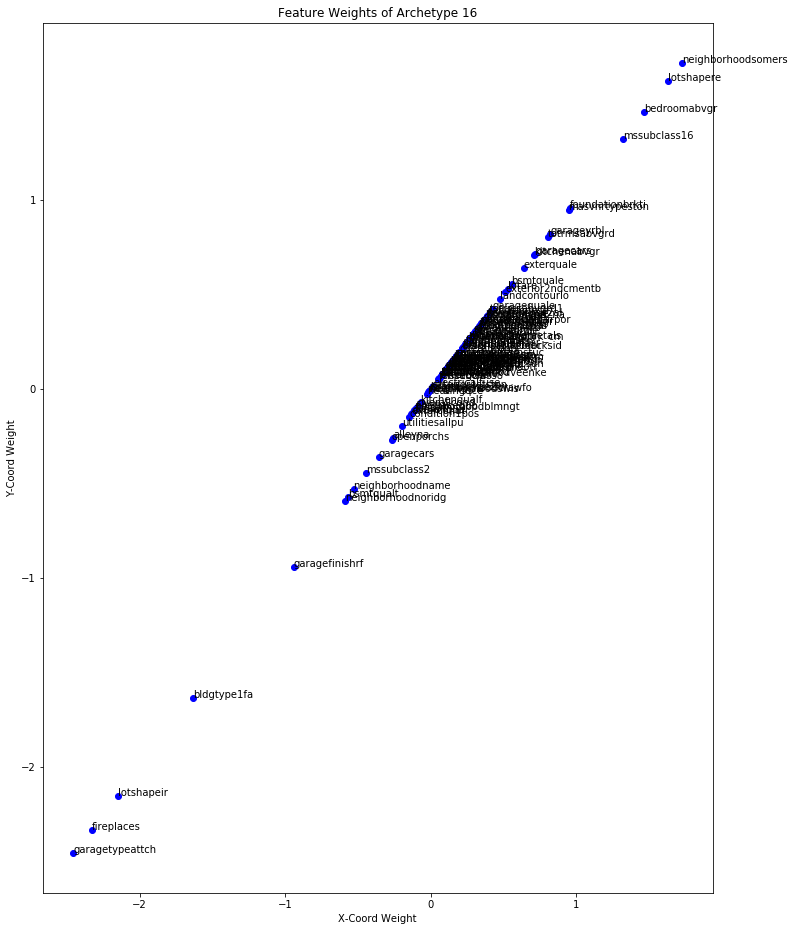

In [ ]:
x_coords = range(1, archs.shape[1], 3)
y_coords = range(1, archs.shape[1], 3)
archs_frame = model_out["archetypes"]
# Plot archetypes on x- vs. y-coordinate features
for k in range(archs.shape[0]):
    x_pts = archs[k, x_coords]
    y_pts = archs[k, y_coords]
    hf = plt.figure(figsize=(12,16))
    ax = hf.add_subplot(1,1,1)
    ax.plot(x_pts, y_pts, 'bo')
    
    # Add feature labels to each point
    feat_names = [nam[:-1] for nam in archs_frame.col_header[1::3]]
    for i in range(len(feat_names)):
        plt.annotate(feat_names[i], xy = [x_pts[i], y_pts[i]])
    ax.set_title("Feature Weights of Archetype " + str(k+1))
    ax.set_xlabel("X-Coord Weight")
    ax.set_ylabel("Y-Coord Weight")
    plt.show()

In [ ]:
pred_h2 = glrmodel_2.predict(khous_h2)
pred_null_h2 = glrmodel_2.predict(khous_null_h2)

In [ ]:
score_glrm(pred_h2, khous_h2)

In [ ]:
score_glrm(pred_null_h2, khous_h2)

In [ ]:
score_glrm(khous_null_h2, khous_h2, clean_col_names=False)